# Use grid search for the optimal hyperparameters $\rho$ and $\tau$ of SOS boosting
The evaluation metrics used here are SNR and R2-score.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
import function as fx
import seaborn as sns

In [13]:
# load the validation data set: manually merged data
noisy_valid = np.load("../data/noisy_train.npy")[8000:10000]
clean_valid = np.load('../data/clean_train.npy')[8000:10000]
clean_valid_4d = np.reshape(clean_valid, (clean_valid.shape[0], clean_valid.shape[1], clean_valid.shape[2], 1))
noisy_valid_4d = np.reshape(noisy_valid, (noisy_valid.shape[0], noisy_valid.shape[1], noisy_valid.shape[2], 1))
print('Data loaded.')
print('The size of the noisy data set is:', noisy_valid.shape)
print('The size of the ground truth data set is:', clean_valid.shape)

# load the model
eta       = 0.00025
lmbd      = 1e-6
prev_model   = '../model/eta{}_lmd{}_model.h5'.format(eta, lmbd)
prev_weights = '../weights/eta{}_lmd{}_weights.h5'.format(eta, lmbd)
model         = load_model(prev_model)
weights       = model.load_weights(prev_weights)
print('Model loaded.')

# Apply CNN denoising
denoised_valid_4d = model.predict(noisy_valid_4d)
denoised_valid    = np.reshape(denoised_valid_4d,(clean_valid.shape[0], clean_valid.shape[1], clean_valid.shape[2]))
print('CNN denoising finished.')

Data loaded.
The size of the noisy data set is: (2, 256, 128)
The size of the ground truth data set is: (2, 256, 128)
Model loaded.
CNN denoising finished.


In [14]:
# calculate the SnR 
print('SNR of the noisy validation set is:',fx.SNR(clean_valid, noisy_valid))
print('SNR of the CNN denoised validation set is:',fx.SNR(clean_valid, denoised_valid))

# calculate the R2-score
print('R2-score of the noisy validation set is:', fx.R2Score(clean_valid, noisy_valid))
print('R2-score of the CNN denoised validation set is:',fx.R2Score(clean_valid, denoised_valid))

SNR of the noisy validation set is: -64.91825323136351
SNR of the CNN denoised validation set is: -1.7247065455787252
R2-score of the noisy validation set is: -148234.234375
R2-score of the CNN denoised validation set is: 0.9289446622133255


In [15]:
# Define the search ranges of rho and tau
rho_vals  = [-1, -0.75, -0.5, -0.25, -0.1, -0.01, 0.01, 0.1, 0.25, 0.5, 0.75, 1]
tau_vals  = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

SNR_valid_bst_matrix = np.zeros((len(rho_vals), len(tau_vals)))
R2_valid_bst_matrix  = np.zeros((len(rho_vals), len(tau_vals)))

print('Grid search started.')
for i, rho in enumerate(rho_vals):
    for j, tau in enumerate(tau_vals):        
        denoised_valid_bst_4d = denoised_valid_4d
        
        for n in range(10):
            denoised_valid_bst_4d = fx.Boost(rho, tau, model, noisy_valid_4d, denoised_valid_bst_4d)
            
        denoised_valid_bst = np.reshape(denoised_valid_bst_4d,(clean_valid.shape[0], clean_valid.shape[1], clean_valid.shape[2]))
  
        R2_valid_bst_matrix[i][j]  = fx.R2Score(denoised_valid_bst, clean_valid)
        SNR_valid_bst_matrix[i][j] = fx.SNR(clean_valid, denoised_valid_bst)
        
print('Grid search finished.')

Grid search started.
Grid search finished.


(12, 0)

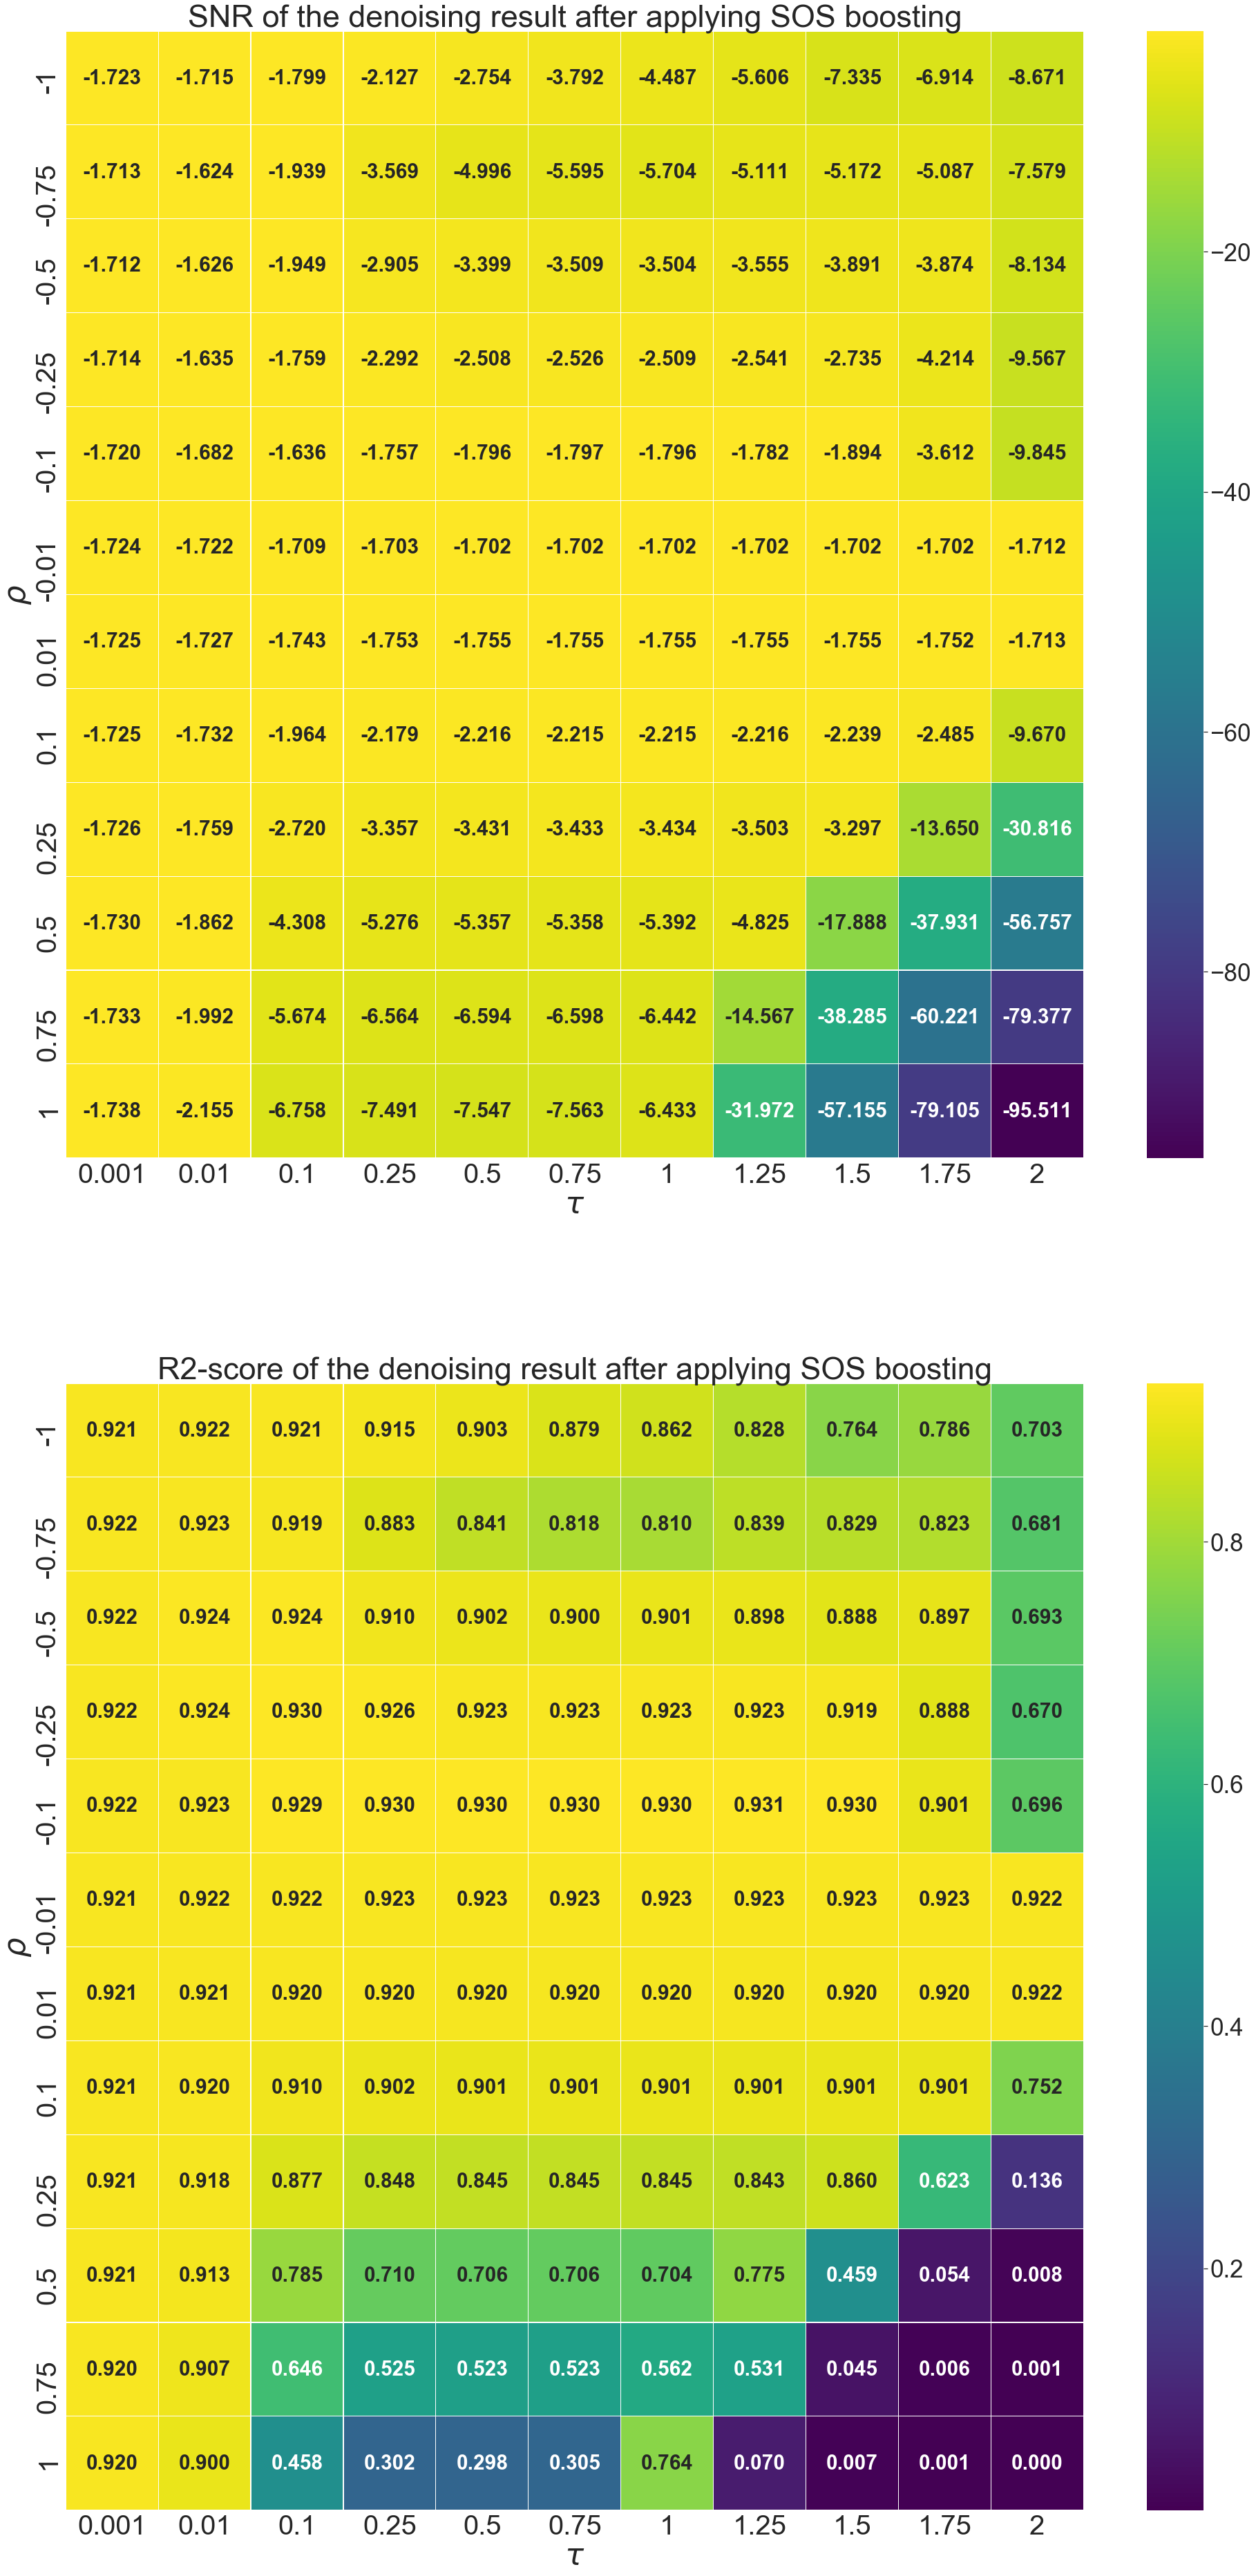

In [16]:
# visual representation of grid search
sns.set()
yticklabels = rho_vals
xticklabels = tau_vals

plt.subplots(figsize = (33, 66))
ax = plt.subplot(2,1,1)
sns.heatmap(SNR_valid_bst_matrix, annot = True, fmt=".3f", linewidths=.1,
               cmap = "viridis",annot_kws={"size": 30, 'weight':'bold'},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)
plt.ylabel(r'$\rho$',fontsize=45);
plt.xlabel(r'$\tau$',fontsize=45);
all_sample_title = 'SNR of the denoising result after applying SOS boosting'
plt.title(all_sample_title, size =45);
ax.tick_params(axis='x', which='major', labelsize=40,pad=1)
ax.tick_params(axis='y', which='major', labelsize=40,pad=1)
ax.set_ylim([len(rho_vals), 0])

ax = plt.subplot(2,1,2)
sns.heatmap(R2_valid_bst_matrix, annot = True, fmt=".3f", linewidths=.1,
               cmap = "viridis",annot_kws={"size": 30, 'weight':'bold'},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)
plt.ylabel(r'$\rho$',fontsize=45);
plt.xlabel(r'$\tau$',fontsize=45);
all_sample_title = 'R2-score of the denoising result after applying SOS boosting'
plt.title(all_sample_title, size=45);
ax.tick_params(axis='x', which='major', labelsize=40,pad=1)
ax.tick_params(axis='y', which='major', labelsize=40,pad=1)
ax.set_ylim([len(rho_vals), 0])

#plt.savefig('../plot_img/boost_grid_search.png', bbox_inches='tight', dpi=200)